# Emittance minimization using Xopt with BAXGenerator running algorithm ScipyMinimizeEmittance
In this notebook we demonstrate the use of Xopt to perform Bayesian Algorithm Execution (BAX) as a means of minimizing the emittance described by a simple optical beam size model. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import sys
# sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.beam_dynamics import compute_emit_bmag
from emitopt.sampling import draw_product_kernel_post_paths
from emitopt.algorithms import ScipyMinimizeEmittanceXY

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
# if torch.cuda.is_available():
if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    use_cuda = True
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

# Notebook settings

In [3]:
ndim = 2 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
thick_quad = False
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 5 #number of random initial observations for GP model
n_samples = 10 #number of posterior samples for BAX
n_iter = 10 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 2

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [4]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

q_len = CONFIG['beamline_info']['Lquad']
rmat_x = torch.tensor(CONFIG['beamline_info']['rMatx']).reshape(2,2)
rmat_y = torch.tensor(CONFIG['beamline_info']['rMaty']).reshape(2,2)

In [5]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])


# define variables functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

scale = 1.e6
def measure_beamsize(input_dict):
    x_tuning = torch.tensor([])
    for key in input_dict.keys():
        if key is not meas_param:
            x_tuning = torch.cat((x_tuning, torch.tensor([input_dict[key]])))
    rms_beamsizes0 = np.array(sim.beam_size_meas(input_dict[meas_param]))
    detuning_scale = 1. + x_tuning.abs().sum().cpu()
    xrms, yrms = detuning_scale * rms_beamsizes0
    return {'xrms_sq': float(xrms)**2.*scale,
            'yrms_sq': float(yrms)**2.*scale} # mean-square beam sizes in mm squared

from emitopt.beam_dynamics import get_quad_scale_factor
scale_factor = get_quad_scale_factor(E=.08, q_len=q_len)
# scale_factor = 1.
q = torch.linspace(-3,3,11)
bss = torch.tensor([np.array(sim.beam_size_meas(v))**2*scale for v in q.numpy()]).T
k = scale_factor*q
ks = torch.stack((k,-k))
rmats = torch.stack((rmat_x, rmat_y))
emit, bmag, sig, is_valid = compute_emit_bmag(ks, bss, q_len, rmats, get_bmag=False, thick=thick_quad)
gt_emit_min = (emit[0]*emit[1]).sqrt()
def ground_truth_geometric_mean_emittance(emit_min, x_tuning):
    detuning_scale = 1. + x_tuning.abs().sum(dim=1)
    emit = emit_min * detuning_scale**2
    return emit

print('Ground truth minimum emit:', gt_emit_min)

Ground truth minimum emit: tensor(0.0609)


# Construct vocs

In [6]:
variables = {var_name: [-1.5,0.5] for var_name in var_names}
variables[meas_param] = [-5,5] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq']
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1']
meas_param = 'x1'
domain =
 [[-1.5  0.5]
 [-5.   5. ]]


# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [7]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator
from emitopt.algorithms import ScipyMinimizeEmittanceXY

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [8]:
from xopt.numerical_optimizer import LBFGSOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_raw_samples=20,
                                    n_restarts=10,
                                    max_iter=50)

# Construct generator, evaluator, Xopt objects

In [9]:
#Prepare Algorithm
algo_kwargs = {
        'x_key': 'xrms_sq',
        'y_key': 'yrms_sq',
        'scale_factor': scale_factor,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 11,
#         'scipy_options': None,
        'thick_quad': thick_quad,
}
algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

#construct evaluator
evaluator = Evaluator(function=measure_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

Verifying model name='standard' use_low_noise_prior=True covar_modules={'xrms_sq': ScaleKernel(
  (base_kernel): ProductKernel(
    (kernels): ModuleList(
      (0): MaternKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (1): PolynomialKernel(
        (raw_offset_constraint): Positive()
      )
    )
  )
  (raw_outputscale_constraint): Positive()
), 'yrms_sq': ScaleKernel(
  (base_kernel): ProductKernel(
    (kernels): ModuleList(
      (0): MaternKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (1): PolynomialKernel(
        (raw_offset_constraint): Positive()
      )
    )
  )
  (raw_outputscale_constraint): Positive()
)} mean_modules={} trainable_mean_keys=[]


# Optimize

In [10]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(n_obs_init)

,x0,x1,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-0.371990,1.696652,0.010636,2.231181,0.001298,False
1,0.448148,2.953514,0.209111,4.758388,0.000317,False
2,-0.599325,-1.192710,0.843145,0.075460,0.000543,False
3,-0.370645,2.003453,0.030264,2.659870,0.000309,False
4,-0.340736,2.331727,0.065305,3.031764,0.000205,False


In [11]:
# torch.tensor(optimizer.data[vocs.variable_names].iloc[-2].to_numpy().reshape(1,-1))

In [12]:
results = {}

In [13]:
# plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
# plt.xlabel('Predicted Optimal Emittance')
# plt.ylabel('Probability Density')
# plt.show()
# print('sample validity rate:', svr)

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP models
    model = optimizer.generator.train_model()
    bax_model_ids = [optimizer.generator.vocs.output_names.index(name)
                            for name in optimizer.generator.algorithm.model_names_ordered]
    bax_model = model.subset_output(bax_model_ids)
    beam_size_model_x = bax_model.models[0]
    beam_size_model_y = bax_model.models[1]
    
    #extract and store algorithm results for this iteration
    results[i] = optimizer.generator.algorithm_results
#     beam_size_models[i] = beam_size_model
    
    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    algo = optimizer.generator.algorithm
#     X_tuned, emits_at_target_valid, svr = algo.mean_output(beam_size_model,
#                                                          torch.tensor(vocs.bounds),
#                                                          num_restarts=10)
    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

#     if i % 5 == 0:
#         plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
#         plt.xlabel('Predicted Optimal Emittance')
#         plt.ylabel('Probability Density')
#         plt.show()
#         print('sample validity rate:', svr)

Iteration: 1 / 10
This iteration took: 5.0662620067596436 seconds.

Iteration: 2 / 10
This iteration took: 3.253800392150879 seconds.

Iteration: 3 / 10
This iteration took: 5.1510419845581055 seconds.

Iteration: 4 / 10
This iteration took: 4.335585117340088 seconds.

Iteration: 5 / 10
This iteration took: 4.125371217727661 seconds.

Iteration: 6 / 10
This iteration took: 5.010940313339233 seconds.

Iteration: 7 / 10
This iteration took: 4.115205764770508 seconds.

Iteration: 8 / 10
This iteration took: 2.9724602699279785 seconds.

Iteration: 9 / 10
This iteration took: 2.9724972248077393 seconds.

Iteration: 10 / 10
This iteration took: 2.151721477508545 seconds.



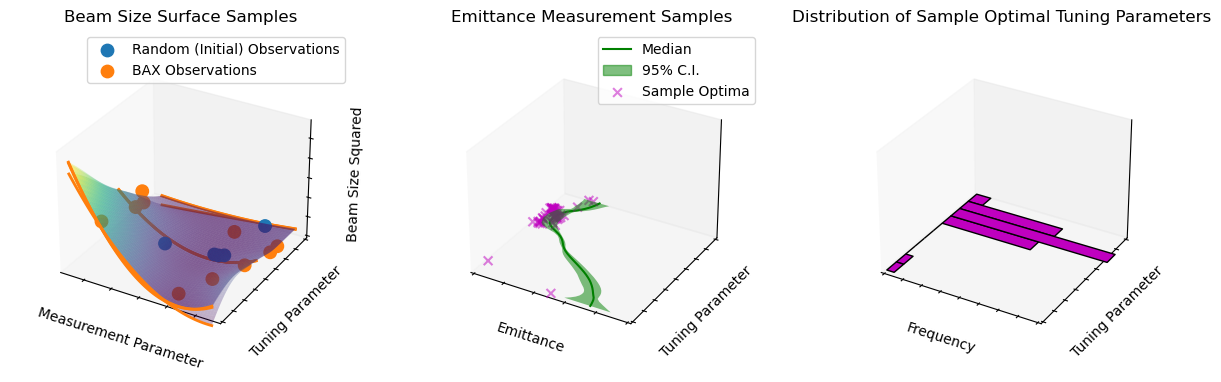

In [15]:
if ndim==2:
    import matplotlib.patches as mpatches
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"})
    fig.set_size_inches(15,10)

    ax = axs[0]

    for s in range(3):

        # plot first 3 beam size surface samples
        xlin, ylin = torch.linspace(-1.5,0.5,50), torch.linspace(-5,5, 50)
        X, Y = torch.meshgrid(xlin, ylin)
        XY = torch.cat((X.reshape(-1,1), Y.reshape(-1,1)), dim=1)
#         print(XY.shape)
        Z = optimizer.generator.algorithm_results['sample_funcs_list'][0](XY)[s].reshape(X.shape).detach()
        cmap='viridis'
        surf = ax.plot_surface(Y, X, Z, cmap=cmap,
                               linewidth=0, antialiased=True, alpha=0.3, rasterized=True)

        # add orange parabolic highlights
        ax.plot(Y[0,:].numpy(), Z[0,:].numpy(), zs=X[0,0].item(), zdir='y', c='C1', lw=2, zorder=10)
        ax.plot(Y[int(len(Z[0,:])/2),:].numpy(), Z[int(len(Z[0,:])/2),:].numpy(), zs=X[int(len(Z[0,:])/2),0].item(), zdir='y', c='C1', lw=2)
        ax.plot(Y[-1,:].numpy(), Z[-1,:].numpy(), zs=X[-1,0].item(), zdir='y', c='C1', lw=2)




    # plot initial observations
    x0 = torch.tensor(optimizer.data['x0'].values)[:n_obs_init]
    x1 = torch.tensor(optimizer.data['x1'].values)[:n_obs_init]
    y = torch.tensor([item.item() for item in optimizer.data['xrms_sq'].values])[:n_obs_init]
    ax.scatter(x1.flatten(), x0.flatten(), y.flatten(), marker='o', c='C0', alpha=1, s=80, label='Random (Initial) Observations', zorder=15)

    # plot bax observations
    x0 = torch.tensor(optimizer.data['x0'].values)[n_obs_init:]
    x1 = torch.tensor(optimizer.data['x1'].values)[n_obs_init:]
    y = torch.tensor([item.item() for item in optimizer.data['xrms_sq'].values])[n_obs_init:]
    ax.scatter(x1.flatten(), x0.flatten(), y.flatten(), marker='o', c='C1', alpha=1, s=80, label='BAX Observations', zorder=15)

    ax.set_title('Beam Size Surface Samples')
    ax.set_ylabel('Tuning Parameter')
    ax.set_xlabel('Measurement Parameter')
    ax.set_zlabel('Beam Size Squared')

#     ax.set_xlim(-3,3)
    ax.set_ylim(-1.5, 0.5)
    ax.set_zlim(0)

    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    ax.legend()
    ax.dist = 12


    # do a scan of the posterior emittance (via valid sampling)
    x_tuning = xlin.reshape(-1,1)
    emit, is_valid, vr = optimizer.generator.algorithm.evaluate_posterior_emittance_samples(bax_model, x_tuning, vocs.bounds)
    quants = torch.tensor([])
    for i in range(len(xlin)):
        svr = torch.sum(is_valid, dim=0)/is_valid.shape[0]
        cut_ids = torch.tensor(range(len(emit[:,i])))[is_valid[:,i]]
        emit_valid = torch.index_select(emit[:,i], dim=0, index=cut_ids)
        ci = 0.95
        q = torch.tensor([(1.-ci)/2., 0.5, (1.+ci)/2.])
        quant = torch.quantile(emit_valid, q=q, dim=0).reshape(1,-1)
        quants = torch.cat((quants, quant))    
    emit_lowers = quants[:,0]  
    emit_meds = quants[:,1] 
    emit_uppers = quants[:,2]  


    #get a few batches of n_samples pathwise sample optima
    x_tuning_best_all = torch.tensor([])
    emit_best_all = torch.tensor([])
    for i in range(5):
        algo = optimizer.generator.algorithm
        results_dict = algo.get_execution_paths(bax_model, torch.tensor(vocs.bounds))[-1]
        x_tuning_best = results_dict['x_tuning_best']
        emit_best = results_dict['emit_best'].detach()
        x_tuning_best_all = torch.cat((x_tuning_best_all, x_tuning_best), dim=0)
        emit_best_all = torch.cat((emit_best_all, emit_best), dim=0)

    ax = axs[1]

    # plot median emittance curve
    medline, = ax.plot(emit_meds.cpu().numpy(), xlin.numpy(), zs=0, zdir='z', c='g', label='Median')

    opt_cross = ax.scatter(emit_best_all.flatten().cpu(), x_tuning_best_all.flatten().cpu(), zs=0, zdir='z', marker='x', s=40, c='m', alpha=0.5, label='Sample Optima')

    # plot emittance 95% confidence interval as a Poly3DCollection (ordering of vertices matters)
    verts = (
        [(emit_lowers[i].item(), xlin[i].item(), 0) for i in range(len(xlin))] + 
        [(emit_uppers[i].item(), xlin[i].item(), 0) for i in range(len(xlin))][::-1]
    )
    ax.add_collection3d(Poly3DCollection([verts],color='g', edgecolor='None', alpha=0.5)) # Add a polygon instead of fill_between


    ax.set_xlabel('Emittance')
    ax.set_ylabel('Tuning Parameter')
    ax.set_title('Emittance Measurement Samples')

    ax.set_xlim(0,0.5)
    ax.set_ylim(-1.5,0.5)
    ax.set_zlim(0,1)

    # remove vertical tick marks
    ax.set_zticks([])

    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    orange_patch = mpatches.Patch(color='g', alpha=0.5, label='95% C.I.')
    ax.legend(handles=[medline, orange_patch, opt_cross])
    ax.dist = 12



    ax = axs[2]
    bins = 10
    freq, edges = torch.histogram(x_tuning_best_all.flatten().cpu(), bins=bins, density=True)
    for i in range(bins):
        uverts = []
        lverts = []
        uverts += [(freq[i].item(), edges[i].item(), 0), (freq[i].item(), edges[i+1].item(), 0)]
        lverts += [(0, edges[i+1].item(), 0), (0, edges[i].item(), 0)]
        verts = uverts + lverts
        ax.add_collection3d(Poly3DCollection([verts],color='m', edgecolor='k')) # Add a polygon instead of fill_between

    ax.set_title('Distribution of Sample Optimal Tuning Parameters')
    ax.set_ylabel('Tuning Parameter')
    ax.set_xlabel('Frequency')

    ax.set_xlim(0,2)
    ax.set_ylim(-1.5,0.5)
    ax.set_zlim(0,1)

    # remove vertical tick marks
    ax.set_zticks([])

    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    ax.dist = 12

#     plt.tight_layout()
#     plt.savefig('beamsize-surfaces-with-emittance-1.svg', format='svg')
#     plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


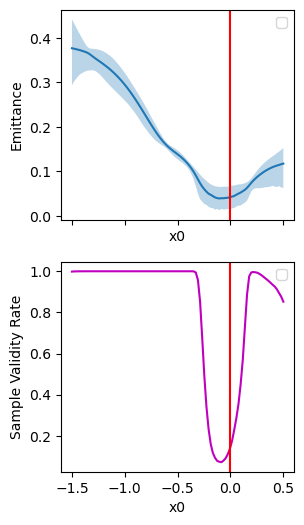

In [16]:
from emitopt.plot_utils import plot_virtual_emittance_vs_tuning
fig, axs = plot_virtual_emittance_vs_tuning(optimizer, torch.tensor([[0.]]))

x_tuning: tensor([[0.]])


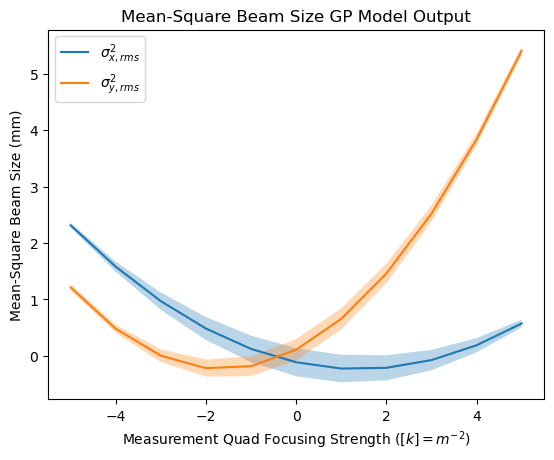

In [17]:
from emitopt.plot_utils import plot_virtual_measurement_scan
plot_virtual_measurement_scan(optimizer, torch.tensor([[0.]]))

get_acquisition took 0.9875507354736328 seconds.
optimize_acqf took 0.9938535690307617 seconds.


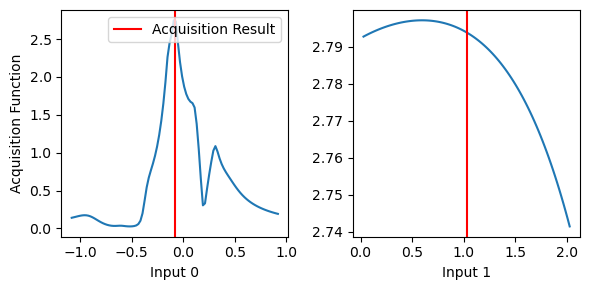

In [18]:
from emitopt.plot_utils import plot_acq_func_opt_results
plot_acq_func_opt_results(optimizer)

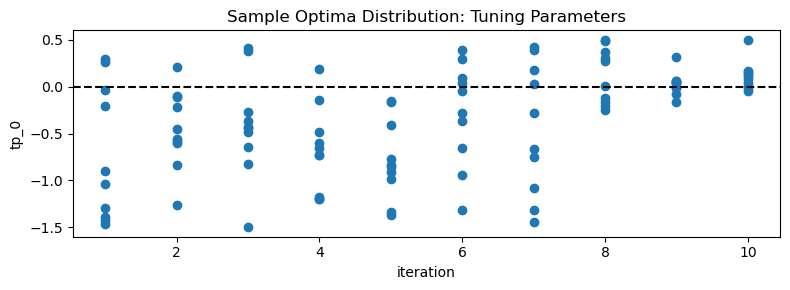

In [19]:
from emitopt.plot_utils import plot_sample_optima_convergence_inputs
fig, axs = plot_sample_optima_convergence_inputs(results, show_valid_only=False)
try:
    for ax in axs:
        ax.axhline(0, ls='--', c='k')
except:
    axs.axhline(0, ls='--', c='k')

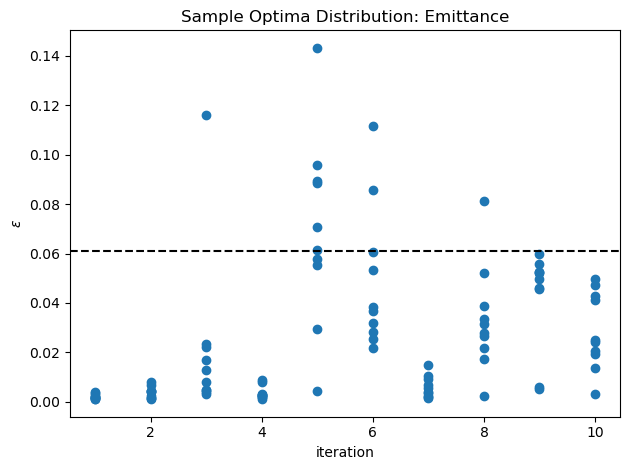

In [20]:
from emitopt.plot_utils import plot_sample_optima_convergence_emits
fig, ax = plot_sample_optima_convergence_emits(results)
ax.axhline(gt_emit_min, ls='--', c='k', label='ground truth')

# Sample emittance scan about minimization result

x_tuning_best = tensor([[[-0.0840]],

        [[ 0.1104]],

        [[ 0.1229]],

        [[ 0.3097]],

        [[-0.0815]],

        [[-0.0771]],

        [[-0.0117]],

        [[-0.1442]],

        [[-0.0862]],

        [[-0.0648]]])
mean: tensor([[-0.0007]])
X_tuned = tensor([[0.1104]])


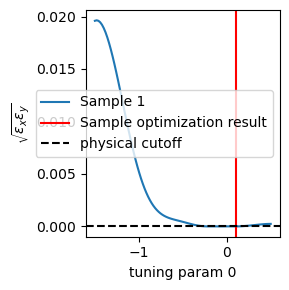

In [21]:
from emitopt.plot_utils import plot_pathwise_sample_emittance_minimization_results

x_tuning_best = optimizer.generator.algorithm_results['x_tuning_best']
print('x_tuning_best =', x_tuning_best)
print('mean:', x_tuning_best.mean(dim=0))

sid = 1
X_tuned = optimizer.generator.algorithm_results['x_tuning_best'][sid:sid+1, 0, :]

fig, axs = plot_pathwise_sample_emittance_minimization_results(optimizer, sid)#, ground_truth_emittance_fn=ground_truth_geometric_mean_emittance)



# X_tuning_scan = X_tuned.repeat(100,1)
# ls = torch.linspace(*optimizer.vocs.bounds.T[0],100)
# X_tuning_scan[:,i] = ls
# gt_emit_xy = ground_truth_geometric_mean_emittance(emit_min=gt_emit_min, x_tuning=X_tuning_scan)
# for ax in axs:
#     ax.plot(ls, gt_emit_xy**4, c='k', label='ground truth')
# #     ax.set_xlim(-0.2,0.2)
# #     ax.set_ylim(0,0.0000005)

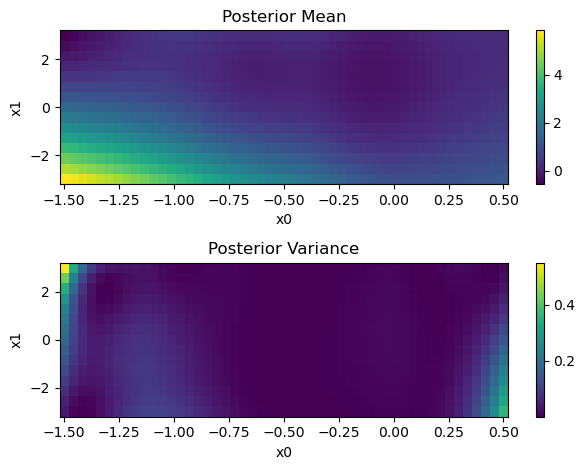

In [22]:
from emitopt.plot_utils import plot_model_cross_section
scan_dict = {'x0':[-1.5,0.5], 'x1': [-3, 3]}
plot_model_cross_section(bax_model.models[0], vocs, scan_dict, nx=50, ny=15)